In [74]:
#%%
import pandas as pd
import plotnine as p9
import numpy as np
import polars as pl
import scipy.stats as stats
from sklearn.model_selection import train_test_split

In [203]:
titles = pl.read_csv("data/title.basics.tsv", separator="\t",  null_values="\\N", dtypes={"endYear": int, "genres":str}, n_rows = 853_568)

In [204]:
titles.select("titleType").unique()

titleType
str
"""short"""
"""tvSpecial"""
"""tvShort"""
"""tvEpisode"""
"""tvSeries"""
"""tvMovie"""
"""movie"""
"""videoGame"""
"""video"""


In [205]:
types = pl.Enum(titles.select("titleType").unique())
titles = (
    titles
    .filter(pl.col("titleType").str.contains("(?i)movie"))
    .with_columns(
        pl.col("titleType").cast(pl.Categorical),
        pl.col("genres").str.split(","),
    )
)


In [5]:
ratings = pl.read_csv("data/title.ratings.tsv",separator="\t",)

In [234]:
title_ratings = (
    titles.join(ratings,on="tconst", how="inner")
)

train_test = np.where(np.random.default_rng(42).random(len(title_ratings))<0.1,"test", "train")
title_ratings = title_ratings.with_columns(train_test = train_test)

title_ratings_train = title_ratings.filter(pl.col("train_test")=="train")

In [ ]:
title_ratings

We filter out films with no ratings 

In [211]:
title_ratings.select('averageRating').describe()

describe,averageRating
str,f64
"""count""",171294.0
"""null_count""",0.0
"""mean""",6.140446
"""std""",1.224275
"""min""",1.0
"""25%""",5.4
"""50%""",6.2
"""75%""",7.0
"""max""",10.0


In [145]:
principals = pl.read_csv("data/title.principals.tsv", separator="\t")

In [259]:
names = pl.read_csv("data/name.basics.tsv", separator="\t", null_values="\\N",)
names.head()

nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
str,str,i64,i64,str,str
"""nm0000001""","""Fred Astaire""",1899,1987,"""actor,miscella…","""tt0072308,tt00…"
"""nm0000002""","""Lauren Bacall""",1924,2014,"""actress,soundt…","""tt0037382,tt00…"
"""nm0000003""","""Brigitte Bardo…",1934,null,"""actress,music_…","""tt0057345,tt00…"
"""nm0000004""","""John Belushi""",1949,1982,"""actor,writer,m…","""tt0072562,tt00…"
"""nm0000005""","""Ingmar Bergman…",1918,2007,"""writer,directo…","""tt0050986,tt00…"


# can use age of actors to differentiate actor popularity 

In [213]:
principals.get_column("category").value_counts()

category,count
str,u32
"""archive_footag…",507274
"""director""",7417673
"""producer""",6481356
"""writer""",10365715
"""casting_direct…",1008036
"""editor""",4508848
"""composer""",2824963
"""actress""",15325804
"""actor""",20502447


In [216]:
actors = principals.filter(pl.col("category").is_in(("actor", "actress")))

In [219]:
actors.shape

(35828251, 6)

In [260]:
actors_rated = (
    title_ratings_train.select(["tconst", 'averageRating', 'numVotes'])
    .join(actors, how="inner", on="tconst")
    .join(names, how="inner", on="nconst")
)

In [236]:
actors_rated.shape

(1344857, 6)

In [261]:
actors_rated.head()

tconst,averageRating,numVotes,ordering,nconst,category,job,characters,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
str,f64,i64,i64,str,str,str,str,str,i64,i64,str,str
"""tt0023926""",6.8,2714,6,"""nm0000001""","""actor""","""\N""","""[""Fred Astaire…","""Fred Astaire""",1899,1987,"""actor,miscella…","""tt0072308,tt00…"
"""tt0025164""",7.4,8740,1,"""nm0000001""","""actor""","""\N""","""[""Guy Holden""]…","""Fred Astaire""",1899,1987,"""actor,miscella…","""tt0072308,tt00…"
"""tt0026942""",7.0,3699,2,"""nm0000001""","""actor""","""\N""","""[""Huck Haines""…","""Fred Astaire""",1899,1987,"""actor,miscella…","""tt0072308,tt00…"
"""tt0027125""",7.7,20890,1,"""nm0000001""","""actor""","""\N""","""[""Jerry Traver…","""Fred Astaire""",1899,1987,"""actor,miscella…","""tt0072308,tt00…"
"""tt0027630""",7.1,4772,1,"""nm0000001""","""actor""","""\N""","""[""Bake Baker""]…","""Fred Astaire""",1899,1987,"""actor,miscella…","""tt0072308,tt00…"


In [268]:
actors_ranking = (
    actors_rated
    .group_by("primaryName","nconst")
    .agg(
        averageRating = (pl.col("averageRating")*pl.col("numVotes")).sum()/pl.col("numVotes").sum(),
        numStars = (pl.col("averageRating")*pl.col("numVotes")).sum(),
        stdevRating = ((pl.col("averageRating")**2)*pl.col("numVotes")).sum()/pl.col("numVotes").sum(), #mean X^2
        numVotes = pl.col("numVotes").sum(),
        numFilms = pl.count()
    ).with_columns(
        stdevRating = (pl.col("stdevRating") - pl.col("averageRating")**2).sqrt()
    )
).sort("numStars", descending=True)
# get actors 'average rating' based on the weighted average of the films they have been in weighted by the votes for the film
# numVotes is a kind of popularity ranking - how many people have seen that actor
# one might want to calculate the averageRating * numVotes - ie total stars received by actor to combine popularity with Rating 
# for average rating / num votes how to handle missing data ( in test set but not in training)


actors_ranking[100:200]

primaryName,nconst,averageRating,numStars,stdevRating,numVotes,numFilms
str,str,f64,f64,f64,i64,u32
"""Mark Wahlberg""","""nm0000242""",7.438044,3.1118e7,0.9653,4183619,21
"""John Lithgow""","""nm0001475""",7.999732,3.0899e7,0.942264,3862551,55
"""Dustin Hoffman…","""nm0000163""",7.362462,3.0786e7,0.615861,4181441,43
"""Danny DeVito""","""nm0000362""",7.467896,3.0763e7,1.020409,4119319,52
"""Jennifer Conne…","""nm0000124""",7.667024,3.0709e7,0.823529,4005333,26
"""Stephen Root""","""nm0740535""",7.803501,3.0661e7,0.551193,3929147,22
"""Ron Dean""","""nm0212939""",8.723621,3.0501e7,0.697162,3496329,15
"""Alfred Molina""","""nm0000547""",7.430799,3.0425e7,0.705837,4094419,46
"""Jeremy Renner""","""nm0719637""",7.75804,3.03125e7,0.504633,3907237,19


In [290]:
cutoff = 10_000
actors_ranking_shortlist = actors_ranking[:cutoff]

In [291]:
title_actors_rated_short = actors_rated.select(pl.exclude(["primaryName","averageRating", "numVotes"])).join(actors_ranking_shortlist, on="nconst", how="inner")
print(title_actors_rated_short.head())
title_actors_rated_short.shape

shape: (5, 16)
┌───────────┬──────────┬───────────┬──────────┬───┬───────────┬─────────────┬──────────┬──────────┐
│ tconst    ┆ ordering ┆ nconst    ┆ category ┆ … ┆ numStars  ┆ stdevRating ┆ numVotes ┆ numFilms │
│ ---       ┆ ---      ┆ ---       ┆ ---      ┆   ┆ ---       ┆ ---         ┆ ---      ┆ ---      │
│ str       ┆ i64      ┆ str       ┆ str      ┆   ┆ f64       ┆ f64         ┆ i64      ┆ u32      │
╞═══════════╪══════════╪═══════════╪══════════╪═══╪═══════════╪═════════════╪══════════╪══════════╡
│ tt0023926 ┆ 6        ┆ nm0000001 ┆ actor    ┆ … ┆ 2097812.6 ┆ 0.409603    ┆ 295801   ┆ 43       │
│ tt0025164 ┆ 1        ┆ nm0000001 ┆ actor    ┆ … ┆ 2097812.6 ┆ 0.409603    ┆ 295801   ┆ 43       │
│ tt0026942 ┆ 2        ┆ nm0000001 ┆ actor    ┆ … ┆ 2097812.6 ┆ 0.409603    ┆ 295801   ┆ 43       │
│ tt0027125 ┆ 1        ┆ nm0000001 ┆ actor    ┆ … ┆ 2097812.6 ┆ 0.409603    ┆ 295801   ┆ 43       │
│ tt0027630 ┆ 1        ┆ nm0000001 ┆ actor    ┆ … ┆ 2097812.6 ┆ 0.409603    ┆ 295801 

(197694, 16)

In [292]:
print(f"getting {cutoff} actors only covers {title_actors_rated_short.get_column('tconst').n_unique()} films of {len(title_ratings_train)}")

getting 10000 actors only covers 67524 films of 154271


In [226]:
actors_rated.filter(pl.col("tconst")=="tt0076759").head(50)

tconst,ordering,nconst,category,job,characters
str,i64,str,str,str,str
"""tt0076759""",1,"""nm0000434""","""actor""","""\N""","""[""Luke Skywalk…"
"""tt0076759""",2,"""nm0000148""","""actor""","""\N""","""[""Han Solo""]"""
"""tt0076759""",3,"""nm0000402""","""actress""","""\N""","""[""Princess Lei…"
"""tt0076759""",4,"""nm0000027""","""actor""","""\N""","""[""Ben Obi-Wan …"
"""tt0076759""",5,"""nm0001088""","""actor""","""\N""","""[""Grand Moff T…"
"""tt0076759""",6,"""nm0000355""","""actor""","""\N""","""[""C-3PO""]"""
"""tt0076759""",7,"""nm0048652""","""actor""","""\N""","""[""R2-D2""]"""
"""tt0076759""",8,"""nm0562679""","""actor""","""\N""","""[""Chewbacca""]"""
"""tt0076759""",9,"""nm0001190""","""actor""","""\N""","""[""Darth Vader""…"


In [150]:
principals.get_column("category").value_counts(sort=True)

category,count
str,u32
"""actor""",20502447
"""actress""",15325804
"""self""",12124895
"""writer""",10365715
"""director""",7417673
"""producer""",6481356
"""editor""",4508848
"""cinematographe…",3450974
"""composer""",2824963


#Plan
1. load relevant data (title/rating/principals)
2. split
3. EDA
4. xgboost model
5. linear model



In [143]:
tgr_explode = title_ratings.explode("genres")
tgr_gp = (
    tgr_explode
    .group_by("genres")
    .agg((pl.col("averageRating")*pl.col("numVotes")).sum()/pl.col("numVotes").sum(),
         pl.col("numVotes").sum(),
         (((pl.col("averageRating")**2)*pl.col("numVotes")).sum()/pl.col("numVotes").sum()).alias("wss")

    )
    .with_columns((pl.col("wss") - pl.col("averageRating")**2).alias("var"))
    .sort("numVotes", descending=True)
)
tgr_gp

genres,averageRating,numVotes,wss,var
str,f64,i64,f64,f64
"""Drama""",7.539222,368530638,57.713637,0.873768
"""Comedy""",6.967635,229136678,49.640144,1.092207
"""Action""",7.11319,206590045,51.775412,1.177945
"""Adventure""",7.275748,184205926,54.03507,1.098563
"""Crime""",7.426698,148450618,56.229038,1.073198
"""Thriller""",7.064677,99373632,50.89948,0.989816
"""Romance""",7.09823,94110534,51.324011,0.939139
"""Sci-Fi""",7.140311,80142934,52.264357,1.280316
"""Mystery""",7.304383,73957075,54.294203,0.940189


/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 1 rows containing missing values.


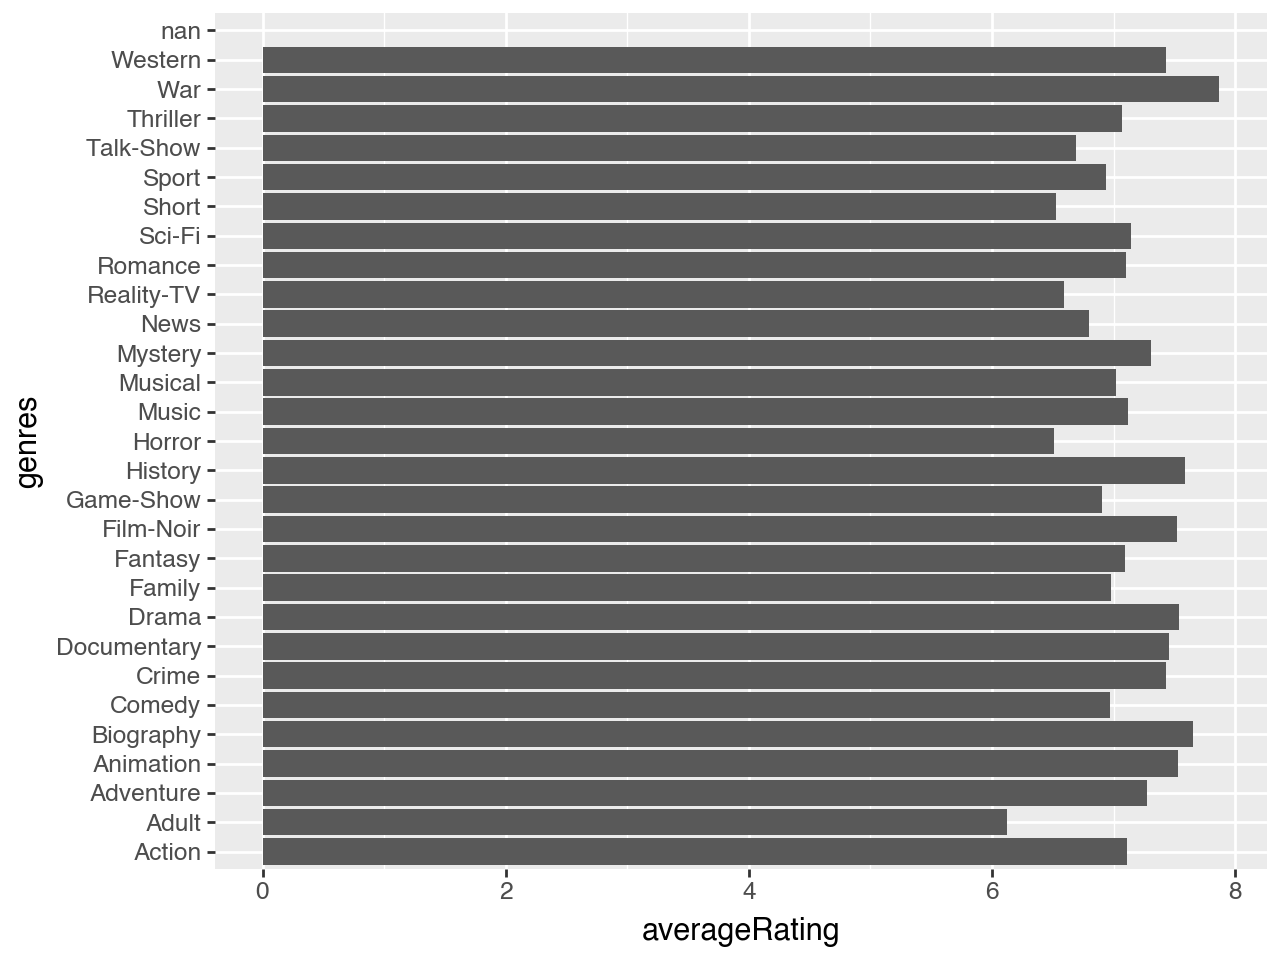

In [139]:
p9.ggplot(tgr_gp,p9.aes(x="genres",y="averageRating"))+p9.geom_bar(stat="identity") +p9.coord_flip()

In [121]:
genres = (
    titles
    .select(["tconst","genres"])
    .explode("genres")
    .to_dummies("genres")
    .group_by("tconst")
    .agg(pl.all().sum().cast(pl.UInt8))
)
title_genres = titles.join(genres, on="tconst", how="left")
title_genres.head()

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genres_Action,genres_Adult,genres_Adventure,genres_Animation,genres_Biography,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Film-Noir,genres_Game-Show,genres_History,genres_Horror,genres_Music,genres_Musical,genres_Mystery,genres_News,genres_Reality-TV,genres_Romance,genres_Sci-Fi,genres_Short,genres_Sport,genres_Talk-Show,genres_Thriller,genres_War,genres_Western,genres_null
str,cat,str,str,i64,i64,i64,i64,list[str],u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
"""tt0000001""","""short""","""Carmencita""","""Carmencita""",0,1894,null,1,"[""Documentary"", ""Short""]",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
"""tt0000002""","""short""","""Le clown et se…","""Le clown et se…",0,1892,null,5,"[""Animation"", ""Short""]",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
"""tt0000003""","""short""","""Pauvre Pierrot…","""Pauvre Pierrot…",0,1892,null,5,"[""Animation"", ""Comedy"", ""Romance""]",0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
"""tt0000004""","""short""","""Un bon bock""","""Un bon bock""",0,1892,null,12,"[""Animation"", ""Short""]",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
"""tt0000005""","""short""","""Blacksmith Sce…","""Blacksmith Sce…",0,1893,null,1,"[""Comedy"", ""Short""]",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [122]:
tgr = title_genres.join(ratings,on="tconst",how="left")

In [112]:
genres.head()

tconst,genres_Action,genres_Adult,genres_Adventure,genres_Animation,genres_Biography,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Film-Noir,genres_Game-Show,genres_History,genres_Horror,genres_Music,genres_Musical,genres_Mystery,genres_News,genres_Reality-TV,genres_Romance,genres_Sci-Fi,genres_Short,genres_Sport,genres_Talk-Show,genres_Thriller,genres_War,genres_Western,genres_null
str,list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8],list[u8]
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [101]:
unique_column_values = title_ratings2.select(pl.col("genres")).unique()


In [103]:
unique_column_values

genres
str
"""Crime"""
"""Music"""
"""Film-Noir"""
"""Animation"""
"""Talk-Show"""
"""News"""
"""Short"""
"""War"""
"""Reality-TV"""


In [ ]:


aggregate_function = lambda col: col.tanh().mean()

df.lazy().group_by(index).agg(

    aggregate_function(values.filter(on == value)).alias(value)

    for value in unique_column_values

).collect()  .pivot("genres")

In [20]:
title_ratings1.head()

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
str,cat,str,str,i64,i64,i64,i64,str,f64,i64
"""tt0000001""","""short""","""Carmencita""","""Carmencita""",0,1894,null,1,"""Documentary""",5.7,2074
"""tt0000001""","""short""","""Carmencita""","""Carmencita""",0,1894,null,1,"""Short""",5.7,2074
"""tt0000002""","""short""","""Le clown et se…","""Le clown et se…",0,1892,null,5,"""Animation""",5.6,279
"""tt0000002""","""short""","""Le clown et se…","""Le clown et se…",0,1892,null,5,"""Short""",5.6,279
"""tt0000003""","""short""","""Pauvre Pierrot…","""Pauvre Pierrot…",0,1892,null,5,"""Animation""",6.5,2066


In [48]:
data_splitter = pl.Series("data",np.where(np.random.default_rng(42).random(len(title_ratings))<0.9,"train","test"))
                          #<0.1,"train","test"))
                          


In [49]:
                          
title_ratings = title_ratings.insert_column(-1, data_splitter)


In [50]:

train = title_ratings.filter(pl.col("data")=="train")

In [51]:
train.shape

(768140, 12)

# EDA

## Ratings and NumVotes

The reliability of the ratings depend on how many people voted. We would expect films with only a handful of votes to have a wider range than films with millions of votes.  Also there is a bias - films with many votes are unlikely to be bad films.

The original user data is a score from 1 - 10.  The data is summarised as an average rating, together with the number of votes.  Num votes is an incomplete estimate of the variability of the mean eg an average rating of 5.5 with 10 people and votes of 1-10, vs 10 people voting .  What we need is the standard deviation (or equivalent) of the original votes as well as just the counts.

We use weighted regression to incorporate the counts ( and the regression assumes a common standard deviation)

An ordinal regression would be a natural fit for the individual user data.  A Beta regression would ensure values only between 0 and 1.
Standard tree based methods like gradient boosting do not extrapolate, and would ensure the 1-10 limit.



shape: (9, 2)
┌────────────┬──────────┐
│ describe   ┆ numVotes │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 429864.0 │
│ null_count ┆ 423704.0 │
│ mean       ┆ 1.823258 │
│ std        ┆ 0.764065 │
│ min        ┆ 0.69897  │
│ 25%        ┆ 1.255273 │
│ 50%        ┆ 1.662758 │
│ 75%        ┆ 2.212188 │
│ max        ┆ 6.466885 │
└────────────┴──────────┘


/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 49556 rows containing non-finite values.


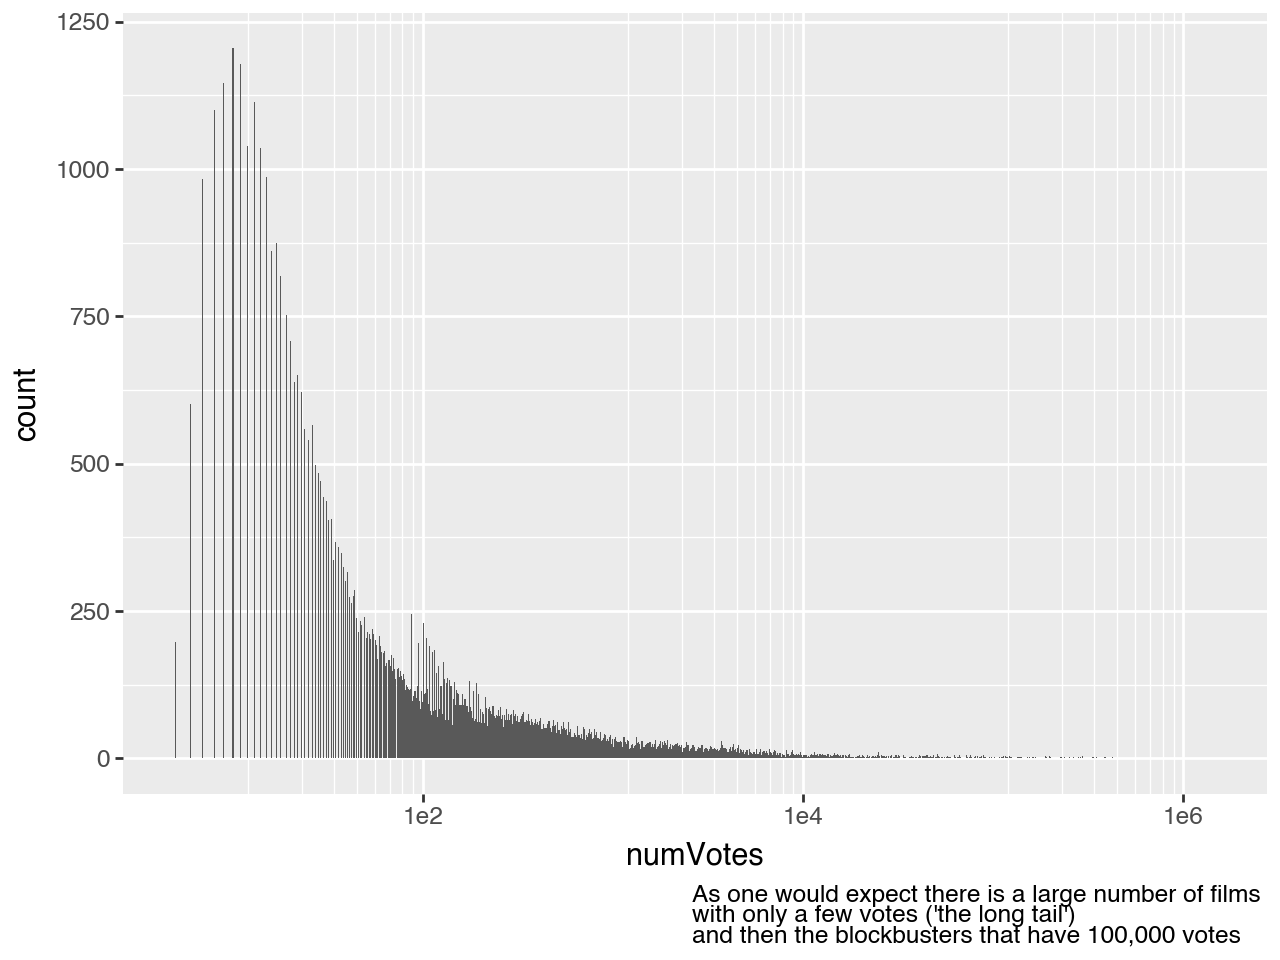

In [162]:
print(title_ratings.select(pl.col("numVotes").log10()).describe())
p9.ggplot(title_ratings.sample(100_000),p9.aes(x="numVotes"))+p9.geom_histogram(bins=1000)+p9.scale_x_log10()+p9.labs(caption="As one would expect there is a large number of films \nwith only a few votes ('the long tail') \nand then the blockbusters that have 100,000 votes")


/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 49632 rows containing missing values.


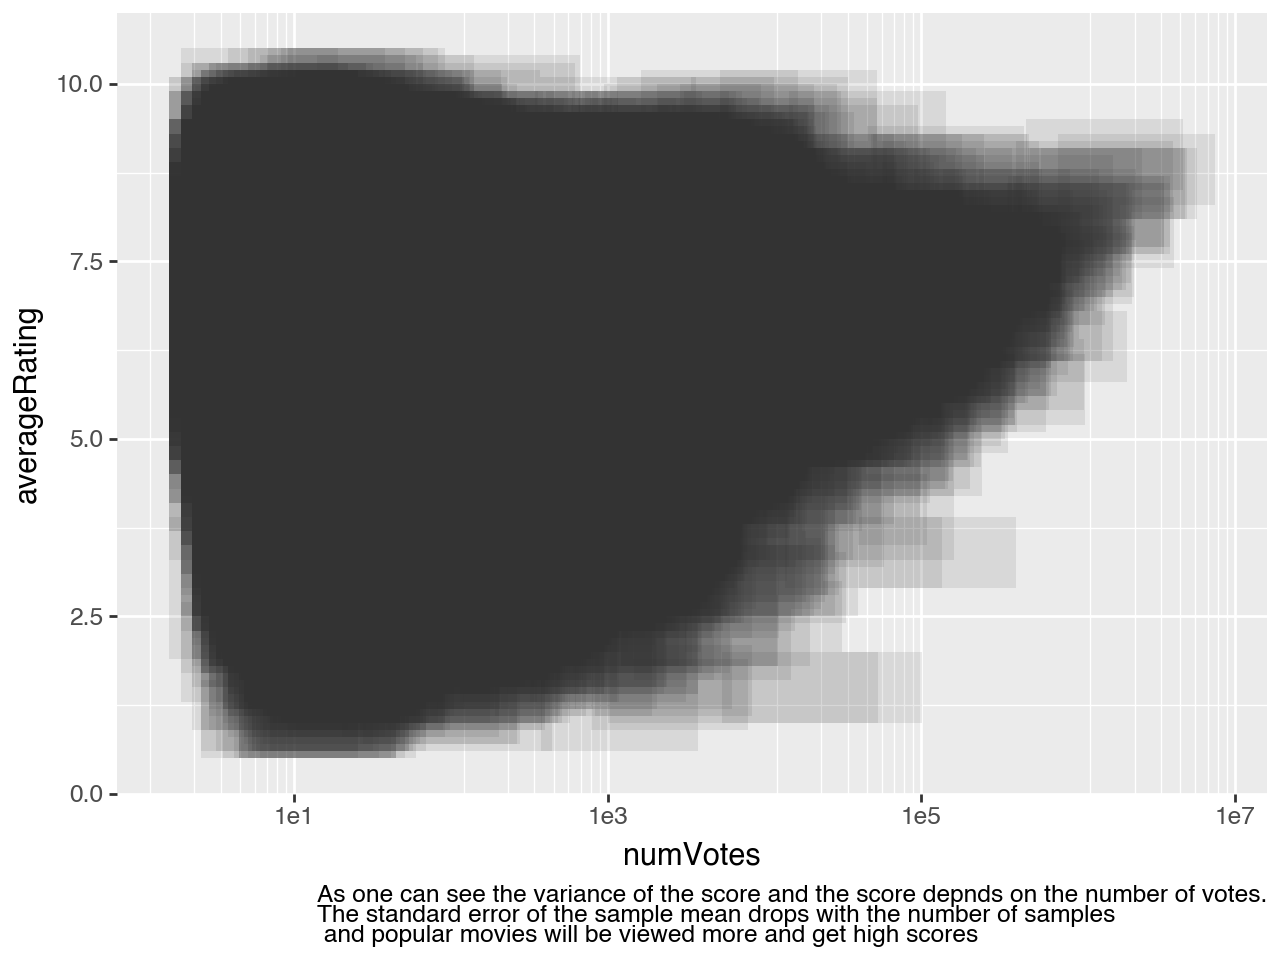

In [163]:
p9.ggplot(title_ratings.sample(100_000),p9.aes(x="numVotes", y="averageRating"))+p9.geom_tile(alpha=0.1)+p9.scale_x_log10() +p9.labs(caption="As one can see the variance of the score and the score depnds on the number of votes.\nThe standard error of the sample mean drops with the number of samples\n and popular movies will be viewed more and get high scores")

shape: (9, 2)
┌────────────┬───────────────┐
│ describe   ┆ averageRating │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 429864.0      │
│ null_count ┆ 423704.0      │
│ mean       ┆ 6.678464      │
│ std        ┆ 1.29481       │
│ min        ┆ 1.0           │
│ 25%        ┆ 5.9           │
│ 50%        ┆ 6.9           │
│ 75%        ┆ 7.6           │
│ max        ┆ 10.0          │
└────────────┴───────────────┘


/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 252'. Pick better value with 'binwidth'.
/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 423704 rows containing non-finite values.


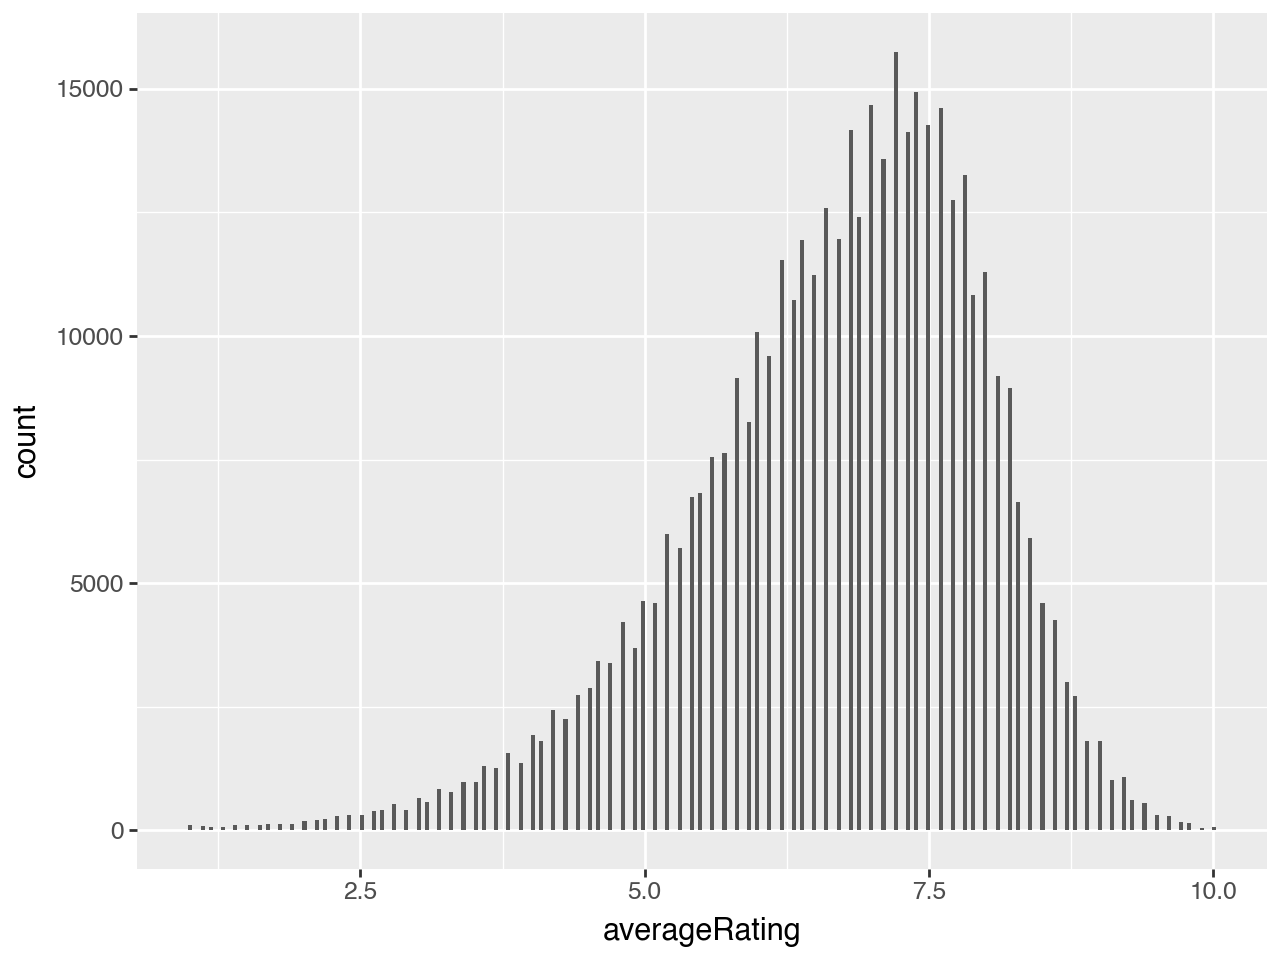

In [164]:
print(title_ratings.select("averageRating").describe())
p9.ggplot(title_ratings,p9.aes(x="averageRating")) + p9.geom_histogram()

In [77]:
zz = stats.beta(a=6.67,b=100).pdf(np.linspace(0,1,20))
zz1 = 

In [191]:
params = stats.beta.fit(ratings.select("averageRating").drop_nulls() -1)

/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


In [192]:
from functools import partial
beta_pdf = partial(stats.beta.pdf, a=params[0], b=params[1],loc=params[2],scale=params[3])
params

(413673.84066553763,
 10.413046311389422,
 -174948.66163400962,
 174959.01861322875)

In [189]:
ratings.head()

tconst,averageRating,numVotes
str,f64,i64
"""tt0000001""",5.7,2074
"""tt0000002""",5.6,279
"""tt0000003""",6.5,2066
"""tt0000004""",5.4,180
"""tt0000005""",6.2,2810


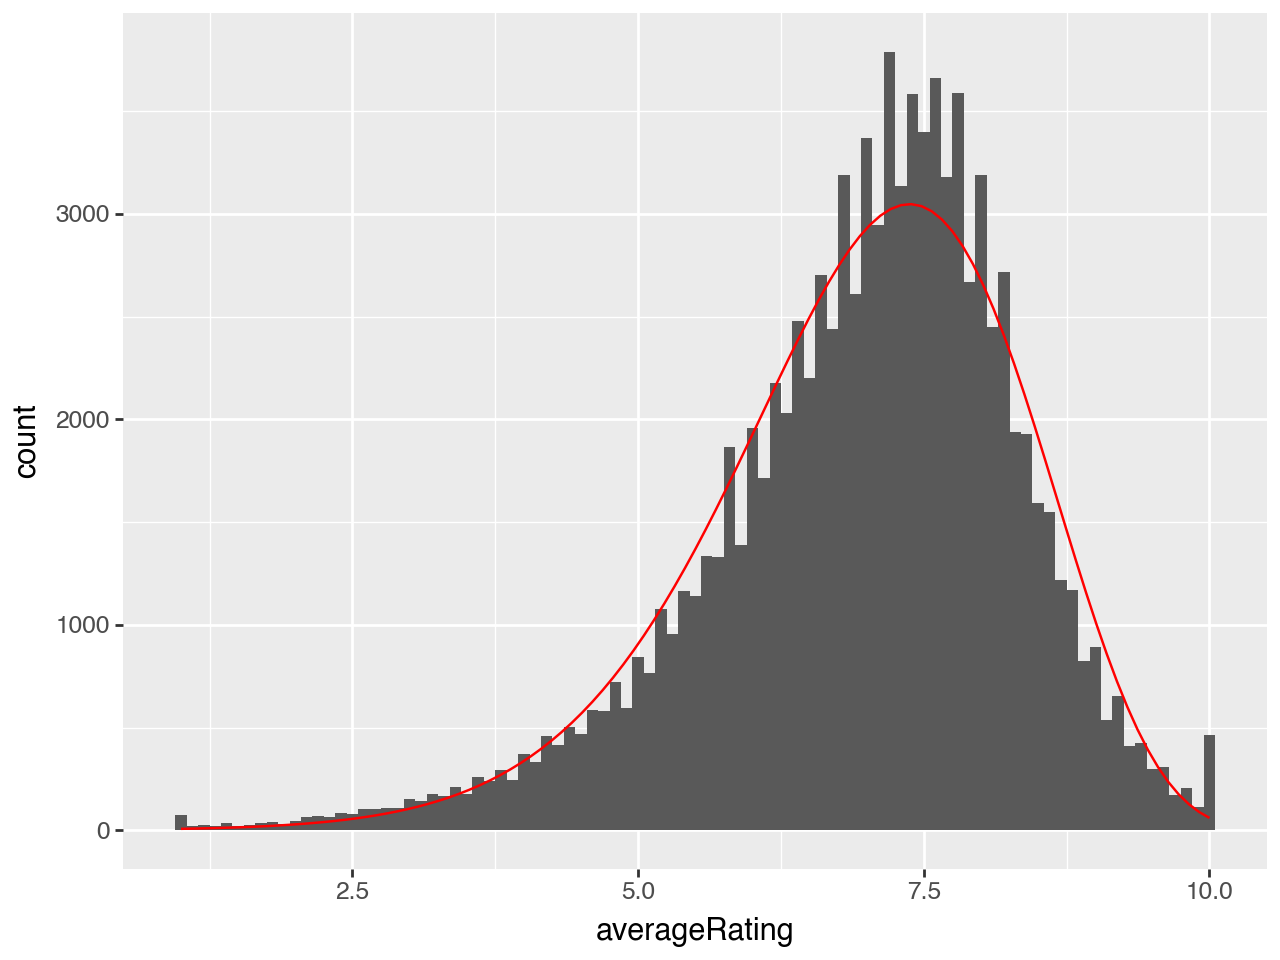

In [194]:
(p9.ggplot((ratings.sample(100_000).select("averageRating") ), p9.aes(x="averageRating"))
 +p9.geom_histogram(binwidth=0.1)
 +p9.stat_function(fun = lambda x: beta_pdf(x-1)*100_000 * .1, colour="red")
)

Ratings are centred 

In [52]:
train.head()

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,data,numVotes
str,cat,str,str,i64,i64,i64,i64,list[str],f64,str,i64
"""tt0000001""","""short""","""Carmencita""","""Carmencita""",0,1894,null,1,"[""Documentary"", ""Short""]",5.7,"""train""",2074
"""tt0000002""","""short""","""Le clown et se…","""Le clown et se…",0,1892,null,5,"[""Animation"", ""Short""]",5.6,"""train""",279
"""tt0000003""","""short""","""Pauvre Pierrot…","""Pauvre Pierrot…",0,1892,null,5,"[""Animation"", ""Comedy"", ""Romance""]",6.5,"""train""",2066
"""tt0000004""","""short""","""Un bon bock""","""Un bon bock""",0,1892,null,12,"[""Animation"", ""Short""]",5.4,"""train""",180
"""tt0000005""","""short""","""Blacksmith Sce…","""Blacksmith Sce…",0,1893,null,1,"[""Comedy"", ""Short""]",6.2,"""train""",2810


In [57]:
ratings_year = title_ratings.group_by("startYear").agg(
    ((pl.col("averageRating")*pl.col("numVotes")).sum()/pl.col("numVotes").sum()).alias("averageRating"),
    pl.col("runtimeMinutes").mean(),
    pl.col("numVotes").sum().alias("numVotes_sum"),
    pl.col("numVotes").mean().alias("numVotes_mean")
).sort("startYear")

/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/seanviolante/miniforge3/envs/ML/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


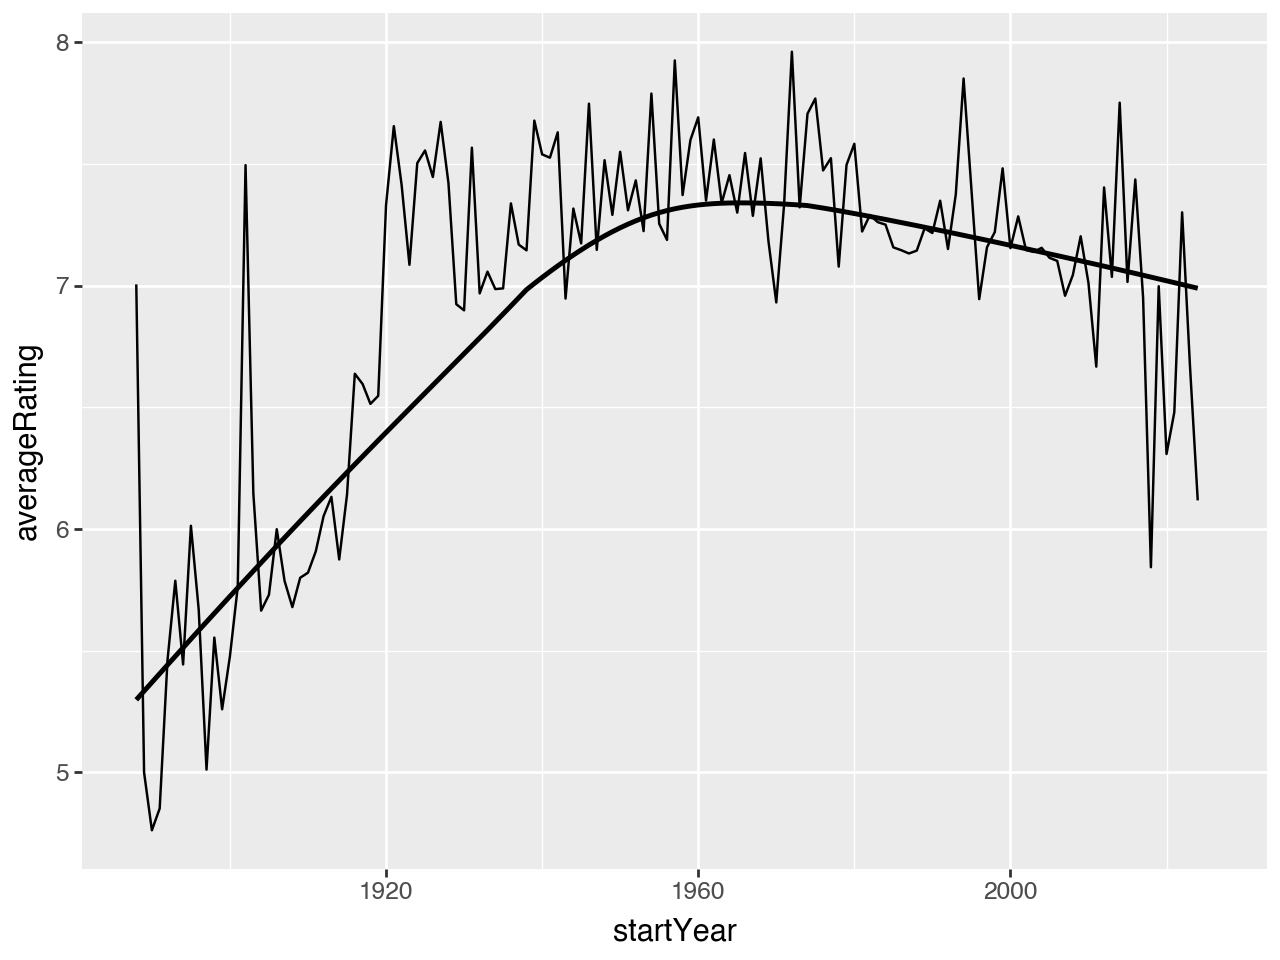

In [61]:
p9.ggplot(ratings_year,p9.aes(x="startYear", y="averageRating")) + p9.geom_line()+p9.geom_smooth()

In [14]:
title_ratings.select("titleType").unique()

titleType
cat
"""short"""
"""movie"""
"""tvShort"""
"""tvMovie"""
"""tvEpisode"""
"""tvSeries"""
"""tvMiniSeries"""
"""tvSpecial"""
"""video"""


In [11]:
y_cols = ["averageRating", "numVotes"]
X = title_ratings.select(pl.exclude(y_cols))




In [ ]:
# %%
filter movie endyear->, runtimeMinutes, genres 
titles1 = titles.




In [12]:
X_train.head()

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
str,cat,str,str,i64,i64,i64,i64,list[str]
"""tt0763252""","""tvEpisode""","""Like a Virgin""","""Like a Virgin""",0,1997,null,22,"[""Comedy"", ""Romance""]"
"""tt0227471""","""tvSeries""","""Senza rete""","""Senza rete""",0,1968,null,null,null
"""tt0750064""","""tvEpisode""","""Jeanette""","""Jeanette""",0,2002,null,47,"[""Action"", ""Crime"", ""Drama""]"
"""tt0690624""","""tvEpisode""","""Episode #5.19""","""Episode #5.19""",0,2004,null,73,"[""Comedy"", ""Talk-Show""]"
"""tt0357438""","""video""","""The Arrangemen…","""The Arrangemen…",1,2002,null,90,"[""Adult"", ""Crime"", ""Drama""]"


In [ ]:
# %%
titles_read = pl.read_csv_batched("data/title.basics.tsv", separator="\t",  null_values="\\N", dtypes={"endYear": int, "genres":str})

dfs = []
batches = titles_read.next_batches(5000)
try:
    for i_batch,batch in enumerate(batches):
        dfs[i_batch] = batch
except Exception as e:
    print(f"failed on {i_batch}")
    print(e)

In [ ]:
# %%
